## Enunciado

> Considere la información del proyecto cuya información aparece en la tabla adjunta:
> 1. Calcule los tres diagramas de Gantt correspondientes al análisis de valor ganado.
> 2. Calcule EV, PV, AC, CPI y SPI para el punto de control actual.
> 3. Calcule utilizando el método de MonteCarlo la duración media y la desviación típica del resto de proyecto que falta por completar. Suponga para ello que la duración aleatoria de las actividades ya empezadas es proporcional a su duración planificada original.


In [1]:
import os, sys

USANDO_COLAB =True
if USANDO_COLAB:
    !apt install libgraphviz-dev              > /dev/null
    %pip install pygraphviz "pandas[excel]"   > /dev/null
    %pip install numpyarray_to_latex          > /dev/null

    repo_url = 'https://github.com/mcasl/pmULE'
    repo_name = "pmULE"


    if not os.path.exists(repo_name):
        print(f"Cloning repository '{repo_name}'...")
        !git clone {repo_url}
        print("Repository cloned successfully!")
    else:
        print(f"Good! No need to download '{repo_name}' again.")

    from google.colab import files
    sys.path.append('pmULE/src')
else:
  sys.path.append('src')

from pmule import PredecessorTable, ProjectGraph, EarnedValue



Cloning repository 'pmULE'...
Cloning into 'pmULE'...
remote: Enumerating objects: 299, done.
remote: Counting objects: 100% (108/108), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 299 (delta 64), reused 7 (delta 2), pack-reused 191 (from 1)
Receiving objects: 100% (299/299), 10.15 MiB | 10.50 MiB/s, done.
Resolving deltas: 100% (165/165), done.
Repository cloned successfully!


In [2]:
# Alargamos el ancho de las celdas al 100%
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

import pandas as pd
pd.set_option('future.no_silent_downcasting', True)

import numpy as np

datos_enunciado = pd.DataFrame([
#  actividad, precedentes, duracion, desviación, coste_planificado, coste_real, duracion_real, realizado
     ('A',      '---    ',       2,          0.5,         60,              80,          2,           100,   ),
     ('B',      '---    ',       2,          0.2,         60,              60,          3,           100,   ),
     ('C',      '---    ',       3,          0.6,         60,              80,          4,           100,   ),
     ('D',      'A      ',       4,          0.1,         40,              60,          5,           100,   ),
     ('E',      'A      ',       1,          0.3,         30,              36,          3,           100,   ),
     ('F',      'E, B   ',       2,          0.7,         12,              12,          3,           100,   ),
     ('G',      'E, B   ',       1,          0.2,         39,              54,          3,           100,   ),
     ('H',      'G, C   ',       4,          0.3,         36,              72,          2,            50,   ),
     ('I',      'D, F   ',       1,          0.7,         90,              90,          2,            60,   ),
     ('J',      'D, F, H',       2,          0.3,         50,               0,          0,             0,   ),
     ('K',      'D, F, H',       2,          0.9,         40,               0,          0,             0,   ),
     ('L',      'I, J   ',       2,          0.3,         30,               0,          0,             0,   ),
     ('M',      'K      ',       2,          0.6,         30,               0,          0,             0,   ),
] ,columns=['actividad', 'precedentes', 'duracion', 'desviacion',
            'coste_planificado', 'coste_real', 'duracion_real', 'realizado']).set_index('actividad')
datos_enunciado

,precedentes,duracion,desviacion,coste_planificado,coste_real,duracion_real,realizado
actividad,,,,,,,
A,---,2,0.5,60,80,2,100
B,---,2,0.2,60,60,3,100
C,---,3,0.6,60,80,4,100
D,A,4,0.1,40,60,5,100
E,A,1,0.3,30,36,3,100
F,"E, B",2,0.7,12,12,3,100
G,"E, B",1,0.2,39,54,3,100
H,"G, C",4,0.3,36,72,2,50
I,"D, F",1,0.7,90,90,2,60


In [3]:
numero_de_muestras = 10

nombres_de_actividades = datos_enunciado.index
np.random.seed(2019)
duraciones_montecarlo = pd.DataFrame([np.random.normal(size = numero_de_muestras,
                                                       loc  = datos_enunciado.duracion[task],
                                                       scale= datos_enunciado.desviacion[task])
                                      for task in nombres_de_actividades],
                                     index=nombres_de_actividades).T.round(1)

In [4]:
duraciones_montecarlo

actividad,A,B,C,D,E,F,G,H,I,J,K,L,M
0,1.9,1.7,2.4,3.9,0.8,2.8,1.3,4.5,1.4,1.8,2.1,1.8,2.6
1,2.4,1.9,3.0,4.0,0.7,1.6,0.6,4.2,2.0,1.8,2.3,1.7,2.0
2,2.7,2.0,1.1,4.1,0.5,1.3,1.0,3.8,0.8,2.1,1.8,2.0,2.8
3,2.7,1.9,3.6,4.0,0.6,1.4,1.1,3.7,0.9,1.9,2.3,2.3,2.6
4,1.8,2.0,3.5,3.9,1.1,2.2,0.7,3.5,1.2,1.9,2.1,1.7,2.8
5,2.3,2.0,3.3,3.9,0.9,2.2,0.9,3.5,0.6,1.8,1.5,2.1,0.7
6,2.3,2.5,3.2,3.9,1.4,3.1,0.9,4.1,1.8,1.9,2.1,1.6,2.2
7,2.1,2.1,3.3,4.1,0.8,1.7,0.9,4.0,0.5,1.4,3.5,2.8,1.4
8,1.9,2.2,2.7,4.1,1.6,1.2,1.0,3.2,0.3,2.1,2.3,1.9,1.7
9,2.5,1.9,2.5,4.0,0.9,1.5,0.7,3.9,1.3,1.6,2.1,1.9,2.0


### Apartado 1

>1. Calcule los tres diagramas de Gantt correspondientes al análisis de valor ganado.

In [5]:
datos_proyecto = datos_enunciado.copy()
prelaciones = PredecessorTable.from_dataframe_of_strings(datos_proyecto, activity='actividad', predecessor='precedentes')
prelaciones.display_immediate_linkage_matrix()

,A,B,C,D,E,F,G,H,I,J,K,L,M
activities,,,,,,,,,,,,,
A,,,,,,,,,,,,,
B,,,,,,,,,,,,,
C,,,,,,,,,,,,,
D,True,,,,,,,,,,,,
E,True,,,,,,,,,,,,
F,,True,,,True,,,,,,,,
G,,True,,,True,,,,,,,,
H,,,True,,,,True,,,,,,
I,,,,True,,True,,,,,,,


La clase PertGraph permite visualizar el grafo PERT, el diagrama de Gantt así como realizar el cálculo de tiempos tempranos, tardíos y de las holguras totales.

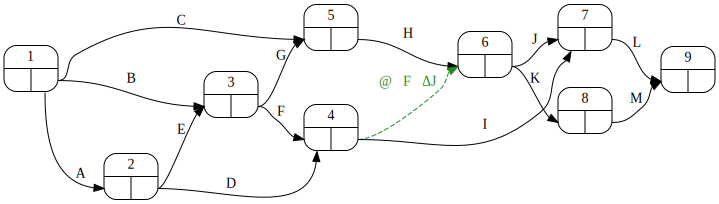

In [6]:
proyecto = prelaciones.create_project()
proyecto.pert()

#### Gantt Valor Planificado

In [7]:
vg = EarnedValue(proyecto)

In [8]:
gantts = vg.calcula_gantts(datos_proyecto,
                           planned_durations_label    = 'duracion',
                           actual_durations_label     = 'duracion_real',
                           PV_label                   = 'coste_planificado',
                           AC_label                   = 'coste_real',
                           percentage_complete_label  = 'realizado'
                          )

In [9]:
gantts['Gantt_PV']

,1,2,3,4,5,6,7,8,9,10,11,12,Total
A,30.000000,30.000000,,,,,,,,,,,60.000000
B,30.000000,30.000000,,,,,,,,,,,60.000000
C,20.000000,20.000000,20.000000,,,,,,,,,,60.000000
D,,,10.000000,10.000000,10.000000,10.000000,,,,,,,40.000000
E,,,30.000000,,,,,,,,,,30.000000
F,,,,6.000000,6.000000,,,,,,,,12.000000
G,,,,39.000000,,,,,,,,,39.000000
H,,,,,9.000000,9.000000,9.000000,9.000000,,,,,36.000000
I,,,,,,,90.000000,,,,,,90.000000
J,,,,,,,,,25.000000,25.000000,,,50.000000


#### Gantt Valor Ganado

In [10]:
gantts['Gantt_EV']

,1,2,3,4,5,6,7,8,9,10,Total
A,30.000000,30.000000,,,,,,,,,60.000000
B,20.000000,20.000000,20.000000,,,,,,,,60.000000
C,15.000000,15.000000,15.000000,15.000000,,,,,,,60.000000
D,,,8.000000,8.000000,8.000000,8.000000,8.000000,,,,40.000000
E,,,10.000000,10.000000,10.000000,,,,,,30.000000
F,,,,,,4.000000,4.000000,4.000000,,,12.000000
G,,,,,,13.000000,13.000000,13.000000,,,39.000000
H,,,,,,,,,9.000000,9.000000,18.000000
I,,,,,,,,,27.000000,27.000000,54.000000
Total,65.000000,65.000000,53.000000,33.000000,18.000000,25.000000,25.000000,17.000000,36.000000,36.000000,373.000000


#### Gantt Coste Real

In [11]:
gantts['Gantt_AC']

,1,2,3,4,5,6,7,8,9,10,Total
A,40.000000,40.000000,,,,,,,,,80.000000
B,20.000000,20.000000,20.000000,,,,,,,,60.000000
C,20.000000,20.000000,20.000000,20.000000,,,,,,,80.000000
D,,,12.000000,12.000000,12.000000,12.000000,12.000000,,,,60.000000
E,,,12.000000,12.000000,12.000000,,,,,,36.000000
F,,,,,,4.000000,4.000000,4.000000,,,12.000000
G,,,,,,18.000000,18.000000,18.000000,,,54.000000
H,,,,,,,,,36.000000,36.000000,72.000000
I,,,,,,,,,45.000000,45.000000,90.000000
Total,80.000000,80.000000,64.000000,44.000000,24.000000,34.000000,34.000000,22.000000,81.000000,81.000000,544.000000


### Apartado 2
> 2. Calcule EV, PV, AC, CPI y SPI para el punto de control actual sin ayudarse de los gráficos de Gantt.


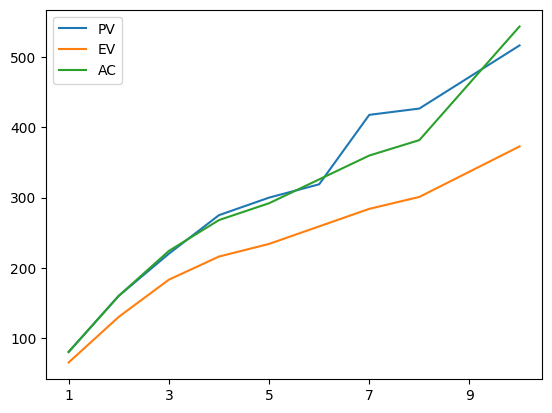

In [12]:
acumulados = gantts['acumulados']
acumulados.plot();

In [13]:
acumulados.tail(1)

,PV,EV,AC
10,517.0,373.0,544.0


In [14]:
EV = acumulados.tail(1)['EV']
EV

,EV
10,373.0


In [15]:
AC = acumulados.tail(1)['AC']
AC

,AC
10,544.0


In [16]:
PV = acumulados.tail(1)['PV']
PV

,PV
10,517.0


In [17]:
CPI = EV/AC
CPI

,0
10,0.685662


In [18]:
SPI=EV/PV
SPI

,0
10,0.72147


### Apartado 3

> 3. Calcule utilizando el método de MonteCarlo la duración media y la desviación típica del resto de proyecto que falta por completar. Suponga para ello que la duración aleatoria de las actividades ya empezadas se calcula de manera proporcional a su duración aleatoria planificada original.


#### Fragmento de proyecto por realizar

In [19]:
prelaciones_restantes = PredecessorTable.from_dict_of_strings(
    { 'H': '',
      'I': '',
      'J': 'H',
      'K': 'H',
      'L': 'I, J',
      'M': 'K'
    }
    )


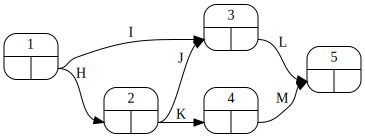

In [20]:
proyecto_restante = prelaciones_restantes.create_project()
proyecto_restante.pert(duraciones=False)

#### Cálculo de las duraciones del resto del proyecto

In [21]:
datos_proyecto_restante = datos_proyecto.copy().drop(['A', 'B', 'C', 'D', 'E', 'F', 'G'])
restantes = datos_proyecto_restante.query('realizado != 100')
duraciones_montecarlo = duraciones_montecarlo.reindex(restantes.index, axis=1)
duraciones_montecarlo = duraciones_montecarlo.eval('H = H * 0.5')
duraciones_montecarlo = duraciones_montecarlo.eval('I = I * 0.4')
duraciones_montecarlo

actividad,H,I,J,K,L,M
0,2.25,0.56,1.8,2.1,1.8,2.6
1,2.10,0.80,1.8,2.3,1.7,2.0
2,1.90,0.32,2.1,1.8,2.0,2.8
3,1.85,0.36,1.9,2.3,2.3,2.6
4,1.75,0.48,1.9,2.1,1.7,2.8
5,1.75,0.24,1.8,1.5,2.1,0.7
6,2.05,0.72,1.9,2.1,1.6,2.2
7,2.00,0.20,1.4,3.5,2.8,1.4
8,1.60,0.12,2.1,2.3,1.9,1.7
9,1.95,0.52,1.6,2.1,1.9,2.0


#### Cálculo de la duración del proyecto

In [22]:
duraciones_caminos =  proyecto_restante.path_matrix(dummies=False) @ duraciones_montecarlo.T
duraciones_caminos

,0,1,2,3,4,5,6,7,8,9
Route_1,2.36,2.5,2.32,2.66,2.18,2.34,2.32,3.0,2.02,2.42
Route_2,5.85,5.6,6.00,6.05,5.35,5.65,5.55,6.2,5.60,5.45
Route_3,6.95,6.4,6.50,6.75,6.65,3.95,6.35,6.9,5.60,6.05


In [23]:
duraciones_proyecto = duraciones_caminos.max(axis="rows")
duraciones_proyecto

,0
0,6.95
1,6.40
2,6.50
3,6.75
4,6.65
5,5.65
6,6.35
7,6.90
8,5.60
9,6.05


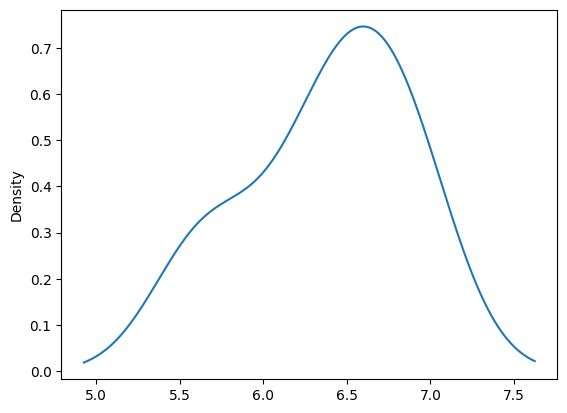

In [24]:
duraciones_proyecto.plot(kind='density');

In [25]:
duraciones_proyecto.mean()

6.380000000000001

In [26]:
duraciones_proyecto.std()

0.4796989796852929